In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_parquet("/content/green_tripdata_2020-07.parquet")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72258 entries, 0 to 72257
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               72258 non-null  int64         
 1   lpep_pickup_datetime   72258 non-null  datetime64[us]
 2   lpep_dropoff_datetime  72258 non-null  datetime64[us]
 3   store_and_fwd_flag     43228 non-null  object        
 4   RatecodeID             43228 non-null  float64       
 5   PULocationID           72258 non-null  int64         
 6   DOLocationID           72258 non-null  int64         
 7   passenger_count        43228 non-null  float64       
 8   trip_distance          72258 non-null  float64       
 9   fare_amount            72258 non-null  float64       
 10  extra                  72258 non-null  float64       
 11  mta_tax                72258 non-null  float64       
 12  tip_amount             72258 non-null  float64       
 13  t

In [3]:
df.drop(columns='ehail_fee', inplace=True, errors='ignore')

In [4]:
df['trip_duration'] = (df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']).dt.total_seconds() / 60

In [5]:
df['weekday'] = df['lpep_dropoff_datetime'].dt.day_name()
print(df['weekday'].value_counts())


weekday
Wednesday    13390
Thursday     13181
Friday       12393
Tuesday      10049
Monday        9576
Saturday      7614
Sunday        6055
Name: count, dtype: int64


In [6]:
df['hourofday'] = df['lpep_dropoff_datetime'].dt.hour
print(df['hourofday'].value_counts())

hourofday
12    5227
10    5201
11    5186
9     4881
16    4827
13    4824
15    4778
14    4728
17    4381
18    4321
8     3942
19    3673
7     2653
20    2384
21    1684
6     1428
22    1292
4     1249
23    1214
1      942
0      923
3      880
5      867
2      773
Name: count, dtype: int64


In [7]:
numeric_cols = df.select_dtypes(include=np.number).columns
object_cols = df.select_dtypes(include='object').columns

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')
df[numeric_cols] = num_imputer.fit_transform(df[numeric_cols])
df[object_cols] = cat_imputer.fit_transform(df[object_cols])

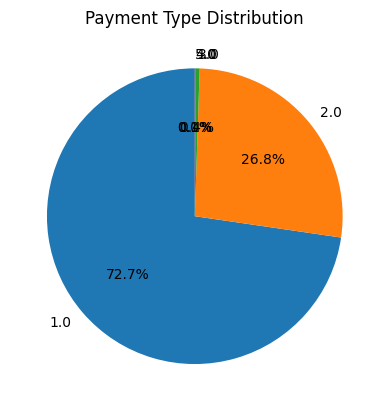

In [8]:
df['payment_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title("Payment Type Distribution")
plt.ylabel('')
plt.show()

In [9]:
print(df.groupby('weekday')['total_amount'].mean())

weekday
Friday       24.020621
Monday       24.104929
Saturday     23.252767
Sunday       23.588813
Thursday     24.780900
Tuesday      24.123400
Wednesday    24.872005
Name: total_amount, dtype: float64


In [10]:
print(df.groupby('payment_type')['total_amount'].mean())

payment_type
1.0    28.718151
2.0    12.430902
3.0     3.482588
4.0     5.669231
5.0     7.966667
Name: total_amount, dtype: float64


In [11]:
trip_type_groups = [group['total_amount'] for name, group in df.groupby('trip_type')]
anova_trip_type = f_oneway(*trip_type_groups)
print("ANOVA on trip_type:", anova_trip_type)

ANOVA on trip_type: F_onewayResult(statistic=np.float64(109.24009820643299), pvalue=np.float64(1.4993900651285336e-25))


In [12]:
weekday_groups = [group['total_amount'] for name, group in df.groupby('weekday')]
anova_weekday = f_oneway(*weekday_groups)
print("ANOVA on weekday:", anova_weekday)

ANOVA on weekday: F_onewayResult(statistic=np.float64(10.691357567277517), pvalue=np.float64(6.519194094669609e-12))


In [13]:
contingency_table = pd.crosstab(df['trip_type'], df['payment_type'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print("Chi-squared Test:", chi2, "p-value:", p)


Chi-squared Test: 206.79431476579302 p-value: 1.2997917545031143e-43


In [14]:
numeric_vars = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
                'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
                'trip_duration', 'passenger_count']

In [15]:
object_vars = ['store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type', 'weekday', 'hourofday']

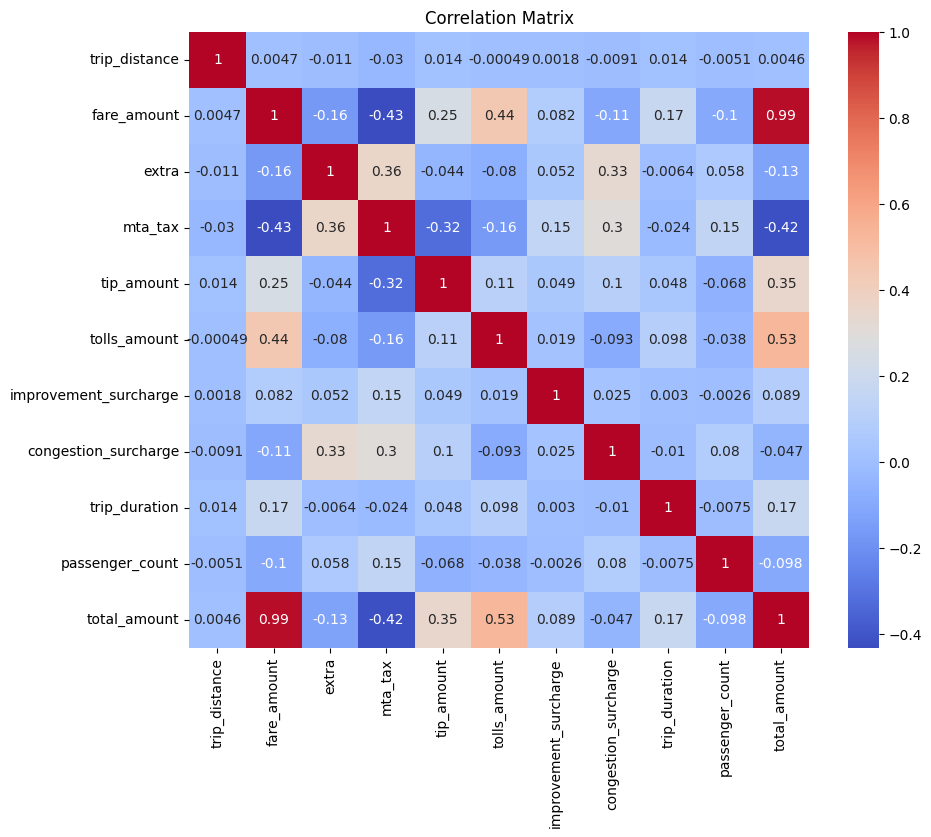

In [16]:
correlation_matrix = df[numeric_vars + ['total_amount']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [17]:
correlation_before_drop = correlation_matrix.copy()

In [18]:
df_encoded = pd.get_dummies(df, columns=object_vars, drop_first=True)

Text(0.5, 1.0, 'Histogram of total_amount')

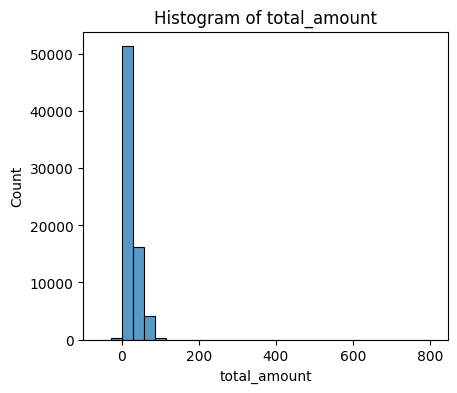

In [19]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
sns.histplot(df['total_amount'], bins=30, kde=False)
plt.title('Histogram of total_amount')

Text(0.5, 1.0, 'Boxplot of total_amount')

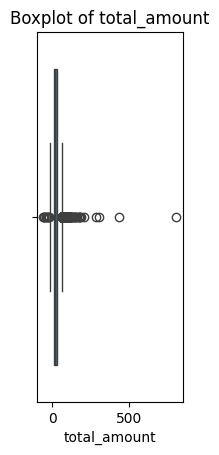

In [20]:
plt.subplot(1, 3, 2)
sns.boxplot(x=df['total_amount'])
plt.title('Boxplot of total_amount')

<ipython-input-21-ab6858b23966>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['total_amount'], shade=True)


Text(0.5, 1.0, 'Density Plot of total_amount')

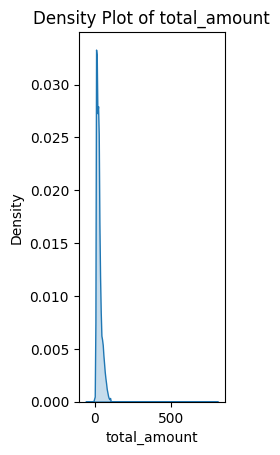

In [21]:
plt.subplot(1, 3, 3)
sns.kdeplot(df['total_amount'], shade=True)
plt.title('Density Plot of total_amount')

In [22]:

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

In [23]:
X = df_encoded.drop(columns=['total_amount', 'fare_amount'])  # Drop fare_amount AFTER correlation
y = df_encoded['total_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Assuming 'df' is your original DataFrame before one-hot encoding:
features_to_exclude = ['total_amount', 'fare_amount', 'lpep_pickup_datetime', 'lpep_dropoff_datetime']
# Add any other columns you don't want in your features

# Select the features for your model
X = df.drop(columns=features_to_exclude)

# One-hot encode the categorical features in X
X_encoded = pd.get_dummies(X, columns=object_vars, drop_first=True)

# Define your target variable
y = df['total_amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Train your Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
print("Linear Regression Score:", lr.score(X_test, y_test))

Linear Regression Score: 0.5221392248252591


In [26]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
print("Decision Tree Score:", dt.score(X_test, y_test))

Decision Tree Score: 0.8171361121818549


In [27]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
print("Random Forest Score:", rf.score(X_test, y_test))

Random Forest Score: 0.8941139905319229


In [28]:
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
print("Gradient Boosting Score:", gb.score(X_test, y_test))

Gradient Boosting Score: 0.8798420152714742


In [29]:
print("Correlation Matrix Before Dropping 'fare_amount':")
print(correlation_before_drop)

Correlation Matrix Before Dropping 'fare_amount':
                       trip_distance  fare_amount     extra   mta_tax  \
trip_distance               1.000000     0.004679 -0.010856 -0.030150   
fare_amount                 0.004679     1.000000 -0.164414 -0.432714   
extra                      -0.010856    -0.164414  1.000000  0.360327   
mta_tax                    -0.030150    -0.432714  0.360327  1.000000   
tip_amount                  0.013837     0.246403 -0.044280 -0.323767   
tolls_amount               -0.000488     0.443664 -0.079573 -0.161613   
improvement_surcharge       0.001757     0.081536  0.052050  0.149542   
congestion_surcharge       -0.009148    -0.111611  0.330179  0.296673   
trip_duration               0.013614     0.172144 -0.006431 -0.024071   
passenger_count            -0.005132    -0.101779  0.058382  0.146935   
total_amount                0.004579     0.987584 -0.129893 -0.416640   

                       tip_amount  tolls_amount  improvement_surcharge  \

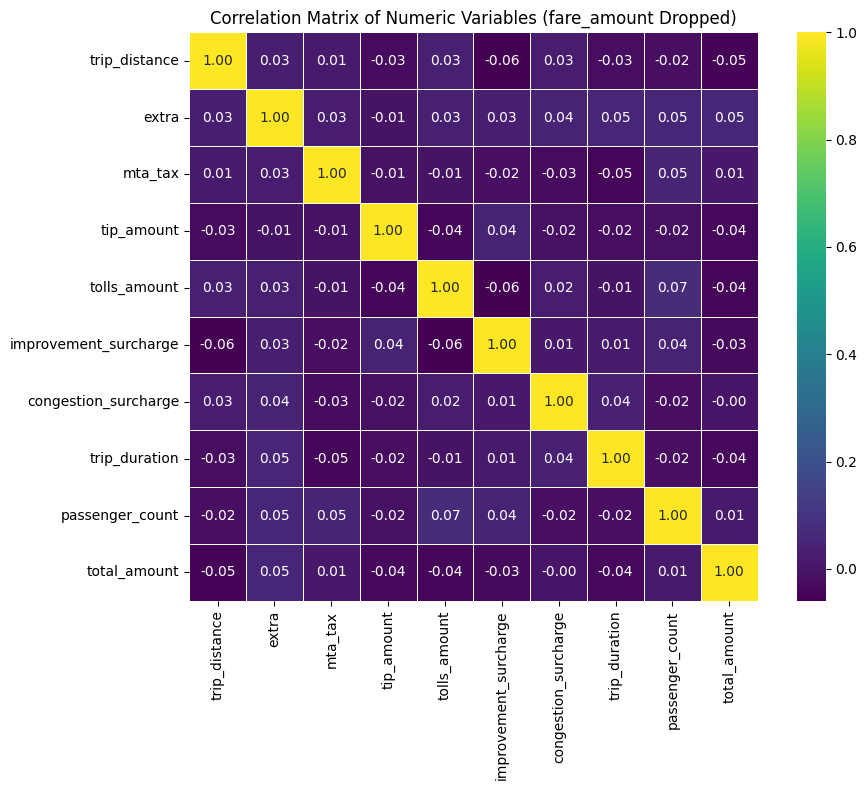

In [32]:
import numpy as np


np.random.seed(42)
mock_data = {
    'trip_distance': np.random.rand(1000) * 10,
    'extra': np.random.rand(1000) * 5,
    'mta_tax': np.random.rand(1000),
    'tip_amount': np.random.rand(1000) * 20,
    'tolls_amount': np.random.rand(1000) * 15,
    'improvement_surcharge': np.random.rand(1000),
    'congestion_surcharge': np.random.rand(1000),
    'trip_duration': np.random.rand(1000) * 60,
    'passenger_count': np.random.randint(1, 6, 1000),
    'total_amount': np.random.rand(1000) * 100,
}

mock_df = pd.DataFrame(mock_data)

correlation_matrix_dropped = mock_df.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_dropped, annot=True, cmap='viridis', fmt=".2f", square=True, linewidths=.5)
plt.title("Correlation Matrix of Numeric Variables (fare_amount Dropped)")
plt.tight_layout()
plt.show()